In [ ]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
              'width': 1000,
              'height': 600,
              'scroll': True,
})

# Dotua 
## An Automatic Differentiation Python Package
### Nick Stern, Summer Yuan, Zach Wehrwein, Vincent Viego

## Structure of Presentation
1. Relevance of automatic differentiation
2. Forward mode high level/deep dive
3. Reverse mode background/importance
4. Reverse mode high level/deep dive
5. Newton Raphson + Neural Network Demos

## Automatic Differentiation - Why Does it Matter?

* ### What is automatic differentiation?
  * A way to take derivatives quickly with machine precision

* ### How does it work?
  * Propagate derivatives of elementary functions as more complicated ones are built
  <center><img src="images/autodiff_graph.png" width="600"></center>

* ### Why do we care?
  * Derivatives are everywhere!!
  * Tons of numerical simulations involving diffeq’s, i.e. hydrodynamics simulations
    * Nuclear Fusion, Oceanography, Modeling Gravity
  * Applications in optimization
    * Neural Networks
    * Robotics

### Lawrence Livermore National Lab Kinematic Impact Studies:
<center><img src="images/spheral_image.png" width="800"></center>

## Forward Mode at a Glance
### Initializer class: AutoDiff  
* Two object classes:
  * Scalar:
    * Stores value in ._val
    * Stores jacobian in dictionary
    * Allows for “f = x + y”
  * Vector:
    * Permits elementwise operations
    * Stores value in ._val
    * Stores jacobian in dictionary
       * Jacobian refers to elements in vector
       
### Operator class: Operator
* Exactly like numpy but for AutoDiff objects.


### How to Use Forward Mode

In [1]:
from Dotua.autodiff import AutoDiff as ad
from Dotua.operator import Operator as op

In [2]:
x, y = ad.create_scalar([1,2])
f = x - y
f.eval()

-1

## Forward Mode deep dive

### What if users add more variables after some functions are defined?

* Imagine we construct a function f = x + y

* A jacobian is initialized for the variables "x" and "y"

* Everything is fine as long as user only defines functions of "x" and "y"

* However, the user then builds a new function g = a + b, which has a new jacobian containing variables "a" and "b."

* If they decide to combine them (h = f + g), how do we handle the separate jacobians? 

### Two possible solutions
* Prevent the user from combining functions with separately initialized sets of variables (scalar)
* Merge the jacobians into a dictionary where the keys are the variable objects and new elements are set to 0 (vector)

## Forward Mode Demo: Newton-Raphson Root Approximation

### Some imports...

In [1]:
%matplotlib inline
import sys
from Dotua.autodiff import AutoDiff as ad
from Dotua.operator import Operator as op
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

### The Algorithm:

In [2]:
def NewtonsMethod(func, x0, tol=1e-15, maxiters=1000):
    '''
    Computes the roots of func through iterative guesses until change is below tolerance.

    Takes in a function (func), a point at which to estimate (x0),
        an error tolerance (tol), and a maximum number of iterations (maxiters).

    func must be composed of 'AutoDiff.Operator' operations and AutoDiff.Scalar structures.

    Example usage:
    '''

    xn = x0
    steps = []

    for i in range(maxiters):

        # Calculate y at this step.
        y = func(xn)._val

        # Calculate derivative at this step
        dy_dx = list(func(xn)._jacobian.values())[0]

        # If y reaches tolerance, stop
        if abs(y) < tol:
            return xn._val, steps
            break

        else:
            steps.append((xn._val, y))
            # Compute Newton Step
            x_next = y / dy_dx

            # Update X
            xn = xn - x_next


    return xn._val, steps

### Comparison

In [3]:
ans, steps = NewtonsMethod(lambda x: x*x, ad.create_scalar(1))
print('Root Found Using Dotua: ', ans)
print('Root Found Using Standard Library: ', optimize.newton(lambda x: x**2, 1))

Root Found Using Dotua:  2.9802322387695312e-08
Root Found Using Standard Library:  1.5813234334835293e-08


### Let's Visualize It!

In [4]:
import time
from IPython import display

def run_plot():
    xvals = np.linspace(-1,1,100)
    fig, ax = plt.subplots(figsize=(10,6))
    ax.scatter([x[0] for x in steps], [x[1] for x in steps], c='r')
    ax.plot(xvals, xvals**2)
    for step in steps:
        ax.plot([step[0]]*100, np.linspace(-.1, step[1],100), 'r--')
        ax.set_xlabel('X', fontsize=15)
        ax.set_ylabel('Y', fontsize=15)
        ax.set_title('Newton Raphson Demo w/ Autodiff', fontsize=20)
        display.clear_output(wait=True)
        display.display(fig)
        time.sleep(.2)
    display.clear_output(wait=True)

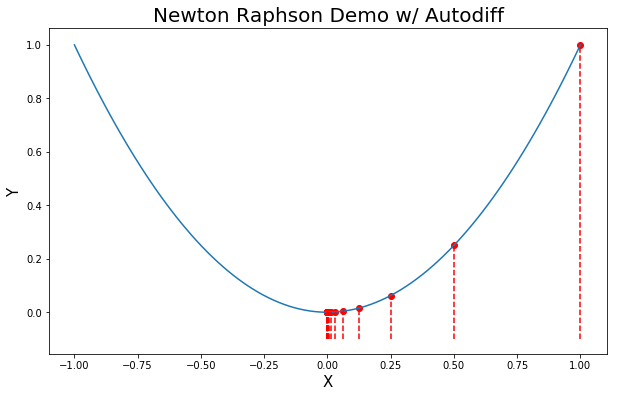

In [5]:
run_plot()

# Reverse Mode Motivation

- Forward mode allows efficient computation of the partial derivatives of multiple functions.

- Reverse mode allows efficient computation of the gradient of a single function.

- In NN: we wish to calculate the slope of each weight w/r/t a loss function.

- AD a necessary aspect of contemporary ML because it allows for us to make this calculation.

For a given input $u$, output $w_1$, and a yet-to-be calculated variable $s$:

Forward mode chain rule:

$$\frac{\partial w}{\partial t} = \frac{\partial w}{\partial u_1} * \frac{\partial u_1}{\partial t} + \frac{\partial w}{\partial u_2} * \frac{\partial u_2}{\partial t} + ...  $$

Backward chain rule (inversion of composite functions by flipping numerator and denominator):

$$\frac{\partial s}{\partial u} = \frac{\partial w_1}{\partial u} * \frac{\partial s}{\partial w_1} + \frac{\partial w_2}{\partial u} * \frac{\partial s}{\partial w_2} + ... $$

- Graph theory intuition most useful.

# Reverse Mode Implementation: High Level

- Efficiency
- Ease of Use
- Expressibility

# Efficiency

- Gradient computaional overhead scales linearly in the number of user defined functions
- Favorable for certain applications in comparison to forward mode where overhead scales linearly in the number of input variables

# Ease of Use

- Comparable to NumPy usage syntax
- Limited initialization

In [9]:
import numpy as np

np.sin(5)

from Dotua.roperator import rOperator as rop
from Dotua.rautodiff import rAutoDiff

rop.sin(5)

rad = rAutoDiff()
x = rad.create_rscalar(5)
rop.sin(x)

## Expressibility

### Given that **Dotua** aims to be a partial NumPy replacement, it is essential that users can be as mathematically expressive with **Dotua** as the can be with NumPy.  

__Operator Support__:
- Basic functions: addition, subtraction, multiplication, division, exponentiation, and negation
- Trigonometric functions: sine, cosine, and tangent
- Inverse trigonometric functions: arcsine, arccosine, arctangent, 
- Hyperbolic functions and their inverses: sine, cosine, and tangents
- Logarithms of any base
- Natural exponentials

__Functional Support__:
- Roots of arbitrary degree
- Logistic functions

In [10]:
from Dotua.roperator import rOperator as rop

# Complex function demo
rad = rAutoDiff()

vals = [0.5, 11, 13, 17, 23, 0.4]
a, b, c, d, f, h = rad.create_rscalar(vals)

func = rop.arccosh(b) / (rop.log(c) ** (rop.arcsin(b ** -2))) + \
       rop.cos((rop.tan(h + a) ** rop.log(d * h, base=2)) / (rop.sin(f) * rop.cos(f)))

print('f: ', func.eval()) 
print('df/da: ', rad.partial(func, a))
print('df/db: ', rad.partial(func, b))
print('df/dc: ', rad.partial(func, c))
print('df/dd: ', rad.partial(func, d))
print('df/de: ', rad.partial(func, f))
print('df/df: ', rad.partial(func, h))

f:  2.578175798120918
df/da:  1.639349254446802
df/db:  -3.0650165357059316
df/dc:  -0.0007596792228180783
df/dd:  0.07206032210419326
df/de:  -2.312173196221017
df/df:  1.639349254446802


# Reverse Mode Implementation: Low Level

- Constructing the computational graph
- Calculating gradients
- Handling multiple functions

## Constructing the Computational Graph

- **rScalar** overloaded operators create intermediary nodes in the computational graph
- The *roots* class attribute of **rScalar** objects stores the computational graph pathway to the input variables. 
- This storage method delays derivative computation until the user specifies the function to be differentiated

In [ ]:
def __init__(self, val):
    self._val = val
    self._roots = {}  # keys are input rScalars, vals are lists of intemediary rScalars
    self._grad_val = 0
    
def _init_roots(self):
    self._roots[self] = [(None, 1)]

- **rOperator** functions also create intermediary nodes in the computational graph
- Dotua's **rOperator** functions can also handle non-rScalar objects (Python numeric types) 

## Calculating Gradients

- The **rAutoDiff** class provides a user interface for calculating derivatives of functions of **rScalar** and **rVector** variables
- The **rScalar** and **rVector** gradient methods use the computational graph representations stored in **rScalar** and **rVector** objects to determine derivatives

- **rScalar** variables recursively use the computational graph defined in *self.roots*
- Derivatives are propagated down to the user defined input variable of interest

## Illustration

<center><img src="images/reverse_graph.png" width="400"></center>

| Node | Children | Roots |
| --- | --- | --- |
| x | sin(x) | { x: (None, 1) } |
| y | sin(x) | { y: (None, 1) } |
| sin(x) | F | { y: (y, dsin(y)/dy) } |
| sin(y) | F | { x: (x, dsin(x)/dx) } |
| F | None | { x: (sin(x), dF/dsin(x)) , y: (sin(y), dF/dsin(y)) } |

## Differentiating Overlapping Computational Graphs

- Initialize and manage **rScalar** objects through a centralized object: **rAutoDiff**
- **rAutoDiff** objects provide user interface for calculating derivatives
- **rAutoDiff** objects "know" when to reset **rScalar** gradient class variables

- **rAutoDiff** objects keep track of user defined **rScalar** objects
- **rAutoDiff** "remember" the last function the user differentiated
- When necessary, **rAutoDiff** objects can reset the gradient values cached in all **rScalar** variables

## Reverse Mode Demo: Neural Network

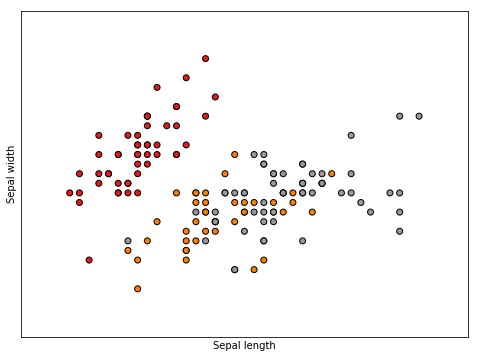

In [11]:
from sklearn import datasets
from sklearn.decomposition import PCA

iris = datasets.load_iris()
X = iris.data
y = iris.target

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(figsize=(8, 6))

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
from Dotua.rautodiff import rAutoDiff as rad
from Dotua.roperator import rOperator as op
import random

rad = rad()

class NeuralNetwork():
    def __init__(self, input_vals, input_bias, hidden_bias, num_hidden, output, learning_rate = 0.1):
        self.input_vals = input_vals
        self.input_bias = input_bias
        self.hidden_bias = hidden_bias
        self.num_hidden = num_hidden
        self.output = output
        self.learning_rate = learning_rate

        self.weights_tohidden = [None] * num_hidden
        for i in range(num_hidden):
            self.weights_tohidden[i] = []
            for j in range(len(input_vals)):
                
                #DOTUA USED HERE: to initalize the weights from the input to hidden layer.
                w = rad.create_rscalar(random.random())
                self.weights_tohidden[i].append(w)
                self.weights_tooutput = [None] * len(output)
        
        for i in range(len(output)):
            self.weights_tooutput[i] = []
            
            #DOTUA USED HERE: to initialize weights from hidden to output.
            w = rad.create_rscalar(random.random())
            for j in range(num_hidden):
                self.weights_tooutput[i].append(w)

    def train(self, input_vals, output_vals):
        self.input_vals = input_vals
        self.output = output_vals

        #calculation of hidden layer.
        self.hidden_layer = []
        for i in range(self.num_hidden):
            h = 0
            for j in range(len(self.weights_tohidden[i])):
                h = h + self.weights_tohidden[i][j] * self.input_vals[j]
            h = h + self.input_bias
            self.hidden_layer.append(1/(1+op.exp(-h)))

        # To calculate the output layer neurons and error
        error = 0
        for i in range(len(self.output)):
            o = 0
            for j in range(len(self.weights_tooutput[i])):
                o = o + self.weights_tooutput[i][j] * self.hidden_layer[j]
            o = o + self.hidden_bias
            o = 1/(1+op.exp(-o))
            error = error + (o - self.output[i]) ** 2

        # To update weights from hidden layer to output layer
        for i in range(len(self.weights_tooutput)):
            for j in range(len(self.weights_tooutput[i])):
                
                #DOTUA USED HERE:
                d = rad.partial(error, self.weights_tooutput[i][j])
                self.weights_tooutput[i][j] = self.weights_tooutput[i][j] - d * self.learning_rate

        # To update weights from input layer to hidden layer
        for i in range(len(self.weights_tohidden)):
            for j in range(len(self.weights_tooutput[i])):
                
                #DOTUA USED HERE:
                d = rad.partial(error, self.weights_tohidden[i][j])
                self.weights_tohidden[i][j] = self.weights_tohidden[i][j] - d * self.learning_rate

    def predict(self, input_vals, output_vals):
        self.input_vals = input_vals
        self.output = output_vals

        # To calculate the hidden layer neurons using the current model
        self.hidden_layer = []
        for i in range(self.num_hidden):
            h = 0
            for j in range(len(self.weights_tohidden[i])):
                h = h + self.weights_tohidden[i][j] * self.input_vals[j]
            h = h + self.input_bias
            self.hidden_layer.append(1/(1+op.exp(-h)))

        # To calculate the output layer neurons using the current model and calculate the error 
        error = 0
        output_layer = []
        for i in range(len(self.output)):
            o = 0
            for j in range(len(self.weights_tooutput[i])):
                o = o + self.weights_tooutput[i][j] * self.hidden_layer[j]
            o = o + self.hidden_bias
            o = 1/(1+op.exp(-o))
            output_layer.append(o.val)
            error = error + (o - self.output[i]) ** 2
        error = error / len(self.output)
        return (output_layer, error.val)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)


def get_y(i):
    train_y = [0,0,0]
    train_y[i] = 1
    return train_y

nn = NeuralNetwork([0,0,0],.33,0,3,[0,0,0])

for j in range(10):
    for i in range(1, len(X_train)):
        nn.train(X_train[i], get_y(y_train[i]))

train_e = []
true_train_y = []
predicted_train_y = []
train_outputs = []
for i in range(1, len(X_train)):
    output,e = nn.predict(X_train[i], get_y(y_train[i]))
    train_e.append(e)
    if max(output) == output[0]:
        predicted_train_y.append(0)
    elif max(output) == output[1]:
        predicted_train_y.append(1)
    else:
        predicted_train_y.append(2)
    true_train_y.append(y_train[i])
    train_outputs.append(output)
    
test_e = []
true_test_y = []
predicted_test_y = []
for i in range(1, len(X_test)):
    output,e = nn.predict(X_test[i], get_y(y_test[i]))
    test_e.append(e)
    if max(output) == output[0]:
        predicted_test_y.append(0)
    elif max(output) == output[1]:
        predicted_test_y.append(1)
    else:
        predicted_test_y.append(2)
    true_test_y.append(y_train[i])

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix

df_cm = pd.DataFrame(confusion_matrix(true_train_y,predicted_train_y),
                     index=['setosa','versicolor','virginica'], columns=['setosa','versicolor','virginica'])
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## References
- https://str.llnl.gov/december-2013/miller 
- https://en.wikipedia.org/wiki/Automatic_differentiation 
- https://rufflewind.com/2016-12-30/reverse-mode-automatic-differentiation

# Questions